In [1]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm#_notebook as tqdm


In [3]:
folderGlob = '/home/rob/HWR/datasets/zooniverse/**/Cropped00[2,4].jpg'
fps = glob(folderGlob)


100%|██████████| 96/96 [00:00<00:00, 169.16it/s]


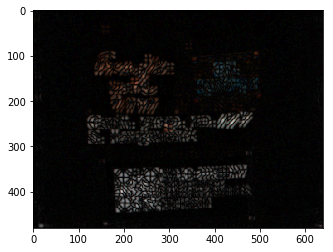

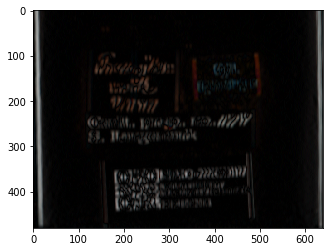

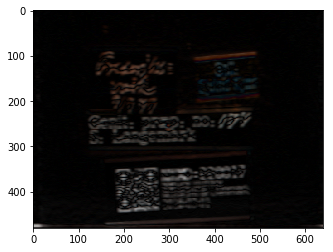

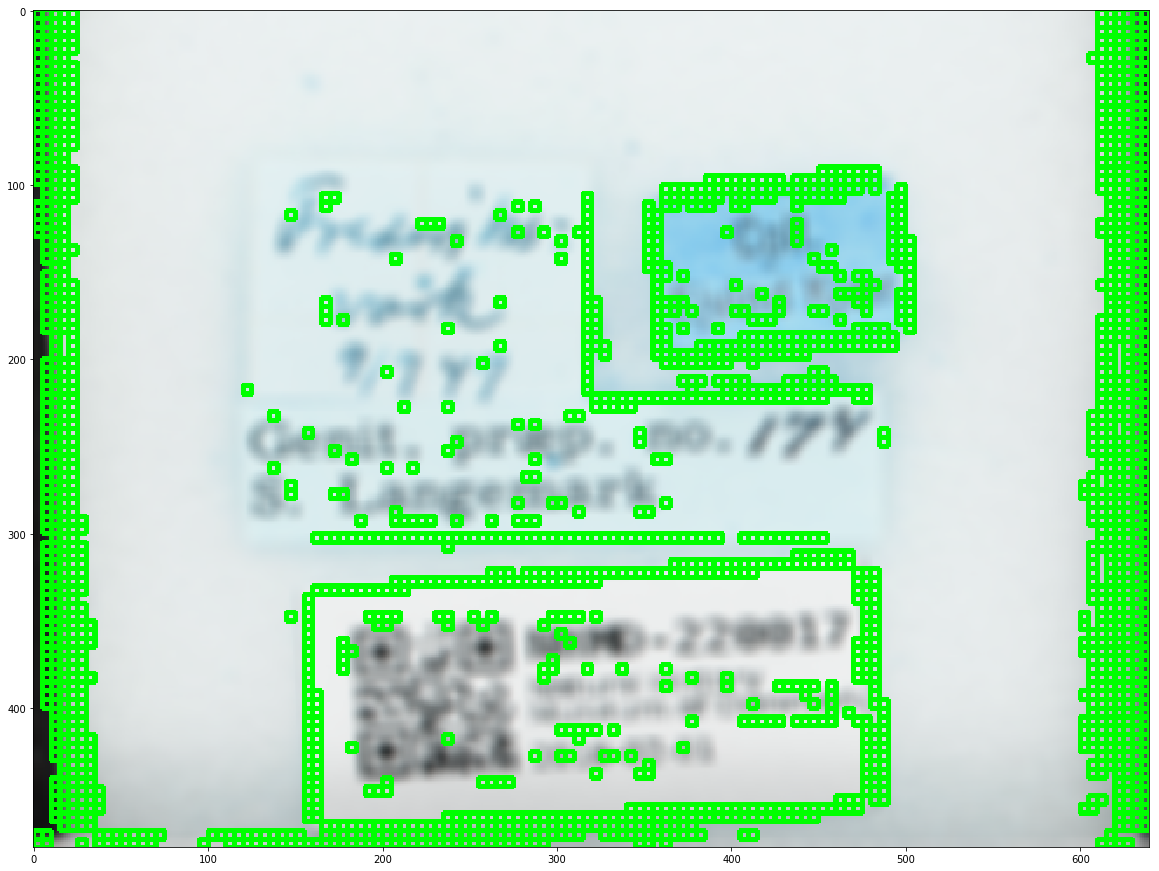

In [7]:
new_size = (160*4,120*4)
height = new_size[1]
width = new_size[0]
num = np.random.randint(3800)

img = cv2.imread(fps[num])
orig_size = img.shape[:2]
img = cv2.resize(img, new_size)
img = cv2.GaussianBlur(img, (11,11), 4)
sobel_xy = sobel(img, 1, 1, 5)
sobel_x = sobel(img, 1, 0, 3)
sobel_y = sobel(img, 0, 1, 3)

plt.figure()
plt.imshow(sobel_xy)
plt.figure()
plt.imshow(sobel_x)
plt.figure()
plt.imshow(sobel_y)

coords = []
threshold = 10
size=5
for j in tqdm(range(height//size)):
    sy = j*size
    ey = j*size + size
    for i in range(width//size):
        sx = i*size
        ex = i*size + size
        
        squ_xy = sobel_xy[sy:ey,sx:ex,:]
        squ_x = sobel_x[sy:ey,sx:ex,:]
        squ_y = sobel_y[sy:ey,sx:ex,:]
        
        mean_xy = squ_xy.mean()
        mean_x = squ_x.mean()
        mean_y = squ_y.mean()
        
        if (mean_xy < threshold) & (max(mean_x, mean_y) > threshold):
            coords += [(sx,sy,ex,ey)]

messy = img.copy()
for (startX, startY, endX, endY) in coords:
    cv2.rectangle(messy, (startX, startY), (endX, endY), (0, 255, 0), 2)
    

plt.figure(figsize=(20,20))
plt.imshow(messy)


NameError: name 'height' is not defined

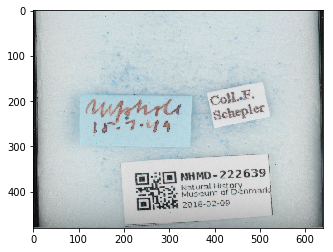

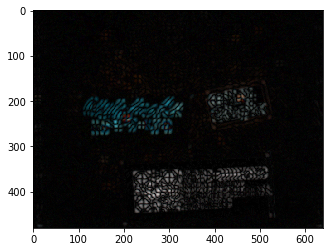

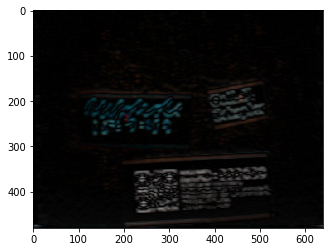

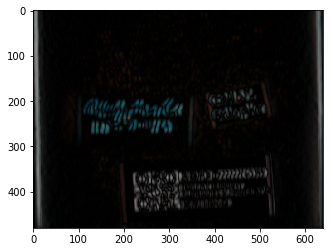

In [6]:
#num = np.random.randint(3800)
img = cv2.imread(fps[num])
orig_size = img.shape[:2]
img = cv2.resize(img, (160*4,120*4))
plt.imshow(img)
img = cv2.GaussianBlur(img, (11,11), 4)
sobelx64f = cv2.Sobel(img,cv2.CV_64F,1,1,ksize=5)
abs_sobel64f = np.absolute(sobelx64f)
sobel_8u = np.uint8(abs_sobel64f)

sobelx64f = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=3)
abs_sobel64f = np.absolute(sobelx64f)
sobel_8u_ = np.uint8(abs_sobel64f)


sobelx64f = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)
abs_sobel64f = np.absolute(sobelx64f)
sobel_8u__ = np.uint8(abs_sobel64f)

plt.figure()
plt.imshow(sobel_8u)
plt.figure()
plt.imshow(sobel_8u_)
plt.figure()
plt.imshow(sobel_8u__)




100%|██████████| 96/96 [00:00<00:00, 446.35it/s]


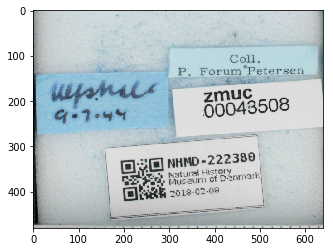

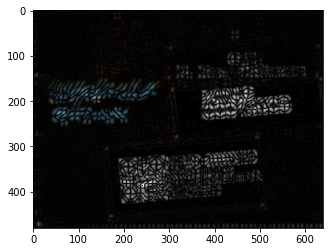

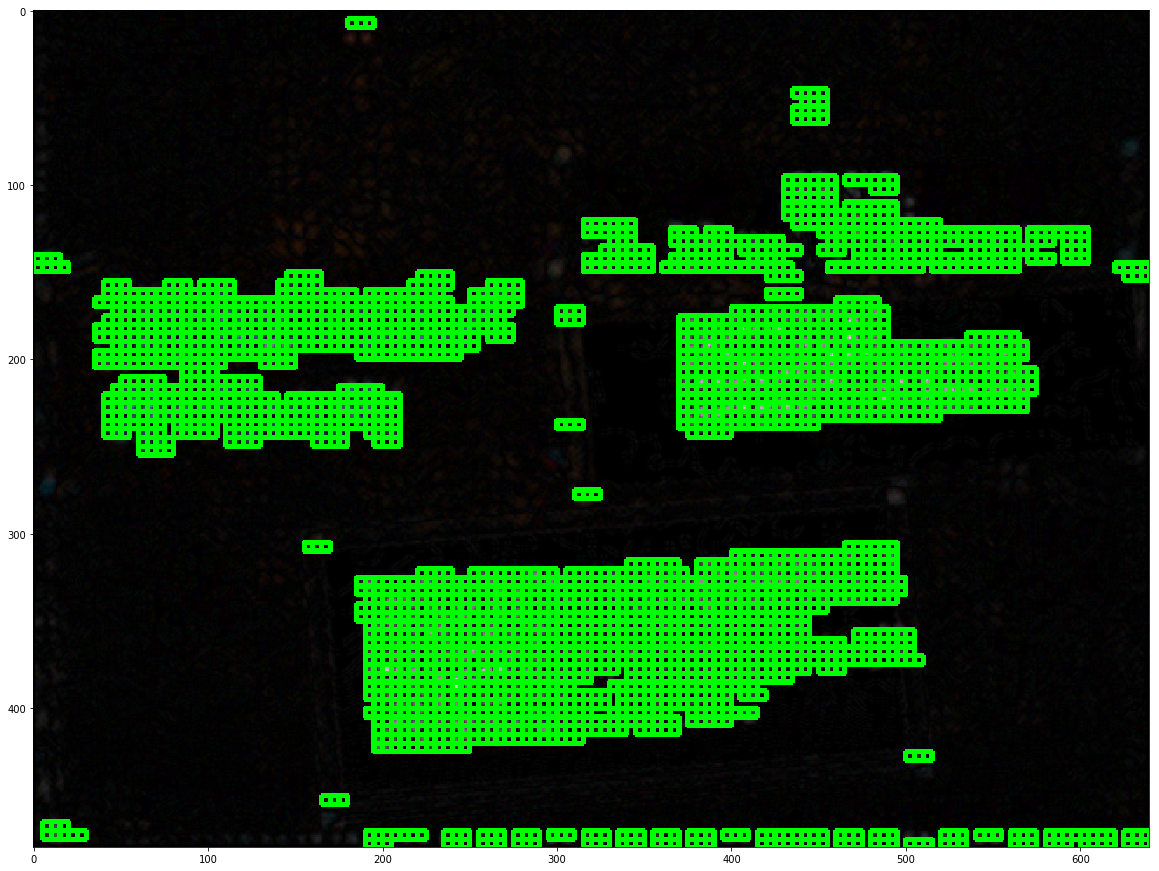

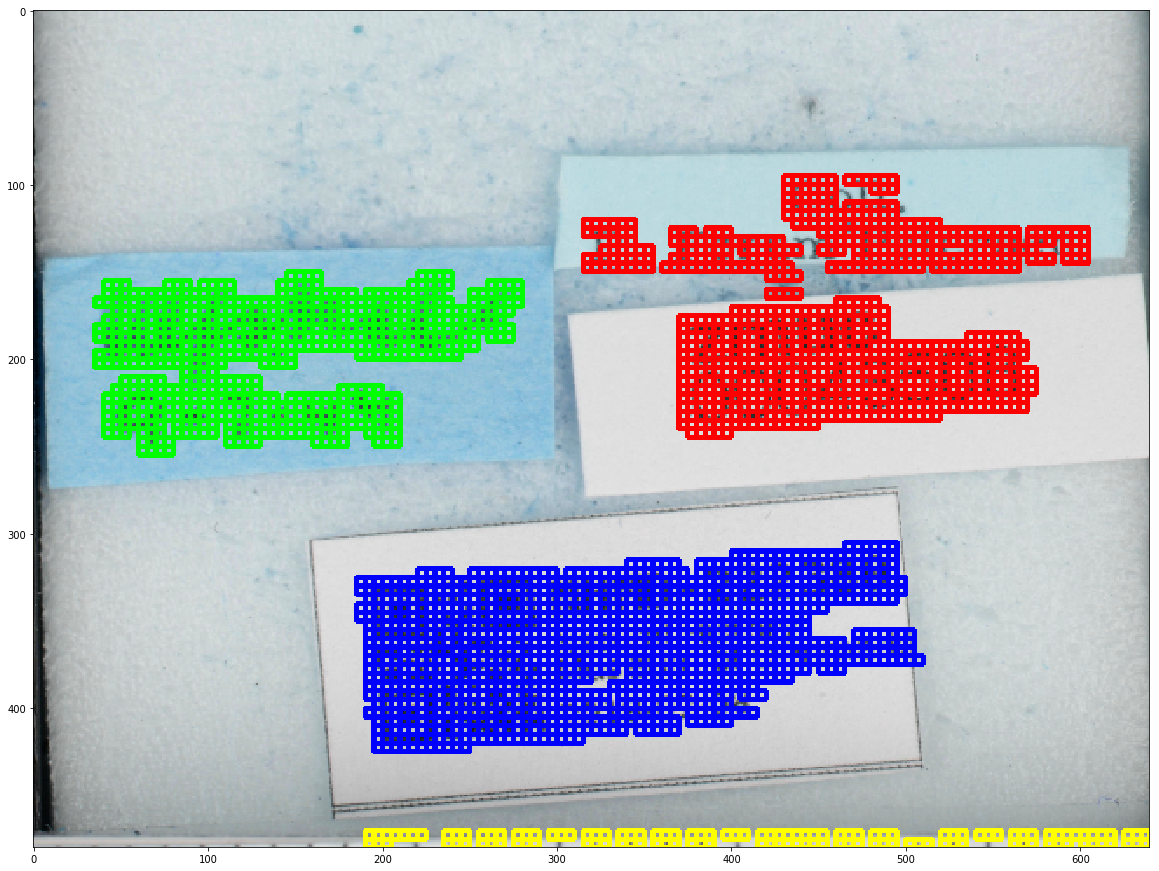

In [61]:
num = np.random.randint(3800)
img = cv2.imread(fps[num])
orig_size = img.shape[:2]
img = cv2.resize(img, (160*4,120*4))
plt.imshow(img)
img = cv2.GaussianBlur(img, (11,11), 4)
sobelx64f = cv2.Sobel(img,cv2.CV_64F,1,1,ksize=5)
abs_sobel64f = np.absolute(sobelx64f)
sobel_8u = np.uint8(abs_sobel64f)
#sobel_8u = cv2.resize(sobel_8u, orig_size[::-1])
plt.figure()
plt.imshow(sobel_8u)

img = sobel_8u.copy()
size = 5
assert size%2 == 1
(height, width, _) = img.shape

#fig=plt.figure(figsize=(25, 45))
columns = width // size
rows = height // size
n_images = columns*rows




k = 1
consecutive = 0 
consecutive_coords = []
text_coords = []
threshold = 10
for j in tqdm(range(height//size)):
    sy = j*size
    ey = j*size + size
    for i in range(width//size):
        sx = i*size
        ex = i*size + size
        
        squ = img[sy:ey,sx:ex,:]
        
        _mean = squ.mean()
        if _mean >= threshold:
            consecutive += 1
            consecutive_coords += [(sx,sy,ex,ey)]
            squ.fill(255)
            squ = squ.astype('uint8')
            
        elif consecutive >= 0:
            if consecutive >= 3:
                consecutive = 0
                text_coords += consecutive_coords
            else:
                consecutive = 0
                consecutive_coords = []
        
        #fig.add_subplot(rows,columns,k)
        #plt.imshow(squ)
        #plt.title(round(squ.mean()))
        k+=1
    
    if consecutive >= 3:
        text_coords += consecutive_coords
    consecutive_coords = []
    consecutive = 0


#plt.show()

messy = sobel_8u.copy()
for (startX, startY, endX, endY) in text_coords:
    cv2.rectangle(messy, (startX, startY), (endX, endY), (0, 255, 0), 2)
    
#plt.figure(figsize=(20,20))
#plt.imshow(messy)

plt.figure(figsize=(20,20))
plt.imshow(messy)

#group into labels
coords_stack = text_coords.copy()
max_dist = size*4

labels = []
while len(coords_stack):
    squ1 = coords_stack[0]
    sx1, sy1, ex1, ey1 = squ1
    mx1 = (sx1+ex1)/2
    my1 = (sy1+ey1)/2
    
    new_label = []
    to_be_checked = [squ1]
    coords_stack.remove(squ1)
            
    while len(to_be_checked):
        squ1 = to_be_checked[0]
        sx1, sy1, ex1, ey1 = squ1
        mx1 = (sx1+ex1)/2
        my1 = (sy1+ey1)/2

        new_label += [squ1]
        to_be_checked.remove(squ1)
        
        coords_stack2 = coords_stack.copy()
        for i in range(len(coords_stack2)):
            squ2 = coords_stack2[i]
            sx2, sy2, ex2, ey2 = squ2
            mx2 = (sx2+ex2)/2
            my2 = (sy2+ey2)/2
            dist = np.sqrt((mx1-mx2)**2 + (my1-my2)**2)
            if dist < max_dist:
                to_be_checked += [squ2]
                coords_stack.remove(squ2)
    labels += [new_label]

img = cv2.imread(fps[num])
img = cv2.resize(img, (160*4,120*4))

colors = [(255,0,0),(0,255,0),(0,0,255),(255,255,0),(255,0,255),(0,255,255),(255,255,255),(100,100,100)]
messy = img.copy()
color = 0
for label in labels:
    if len(label) > 30:
        for (startX, startY, endX, endY) in label:
            cv2.rectangle(messy, (startX, startY), (endX, endY), colors[color], 2)
        color += 1
        if color == len(colors):
            color = 0
            
    
plt.figure(figsize=(20,20))
plt.imshow(messy)

In [39]:
len(labels)
min_area = 2000
label_rects = []
for label in labels:
    label = np.array(label)
    sx = min(label[:,0])
    sy = min(label[:,1])
    ex = max(label[:,2])
    ey = max(label[:,3])
    if (ex-sx)*(ey-sy) >= min_area:
        label_rects += [(sx,sy,ex,ey)]
    else:
        print('yay')
    
for label in label_rects:
    pass

yay
yay
yay
yay
yay
yay
yay
yay


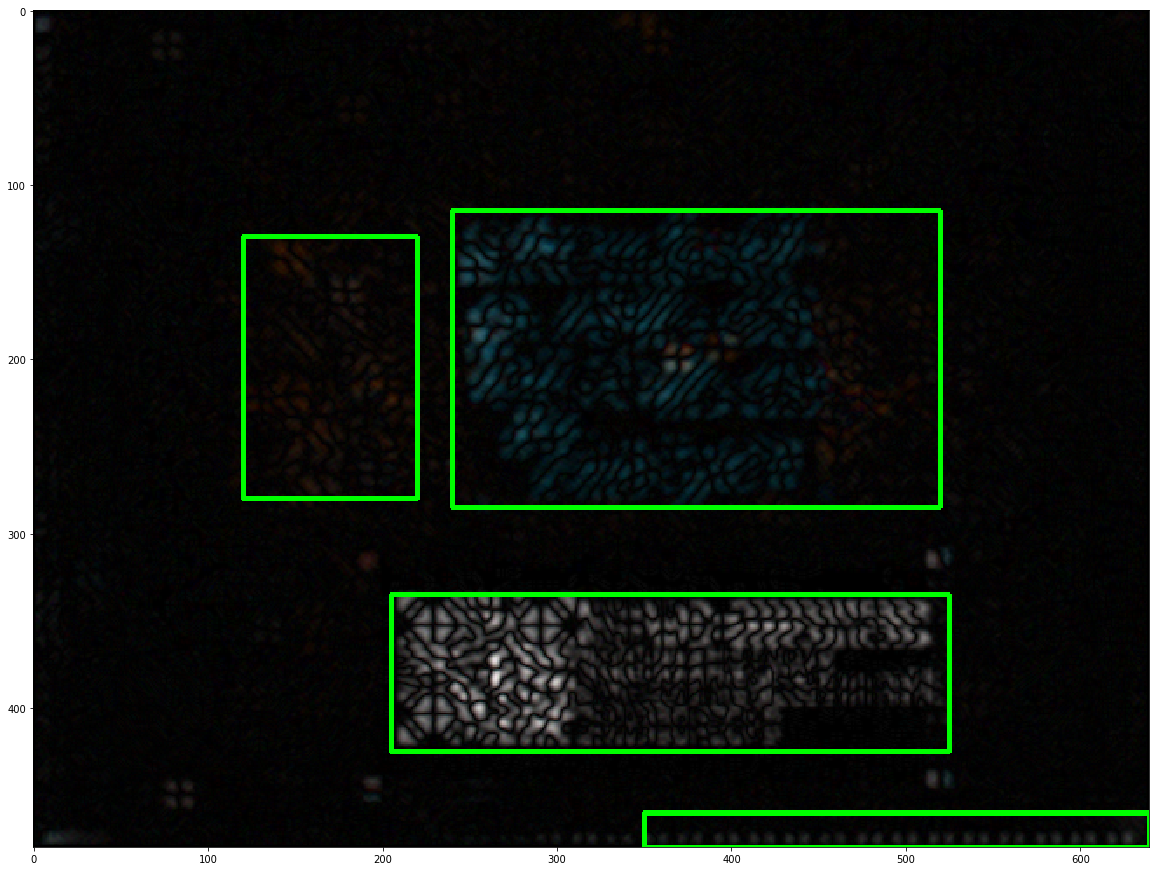

In [40]:
messy = sobel_8u.copy()
for (startX, startY, endX, endY) in label_rects:
    cv2.rectangle(messy, (startX, startY), (endX, endY), (0, 255, 0), 2)
    
plt.figure(figsize=(20,20))
plt.imshow(messy)

In [ ]:
### img = cv2.imread(fps[0])
a = 255*(img[:,:,0]/255)**2
a = a.astype(uint8)
_,a = cv2.threshold(cv2.cvtColor(cv2.merge((a,a,a)), cv2.COLOR_BGR2GRAY),110,255,cv2.THRESH_BINARY_INV)
a = cv2.merge((a,a,a))
plt.imshow(a)

In [139]:
height

2877

[INFO] loading EAST text detector...
[INFO] text detection took 4.145338 seconds


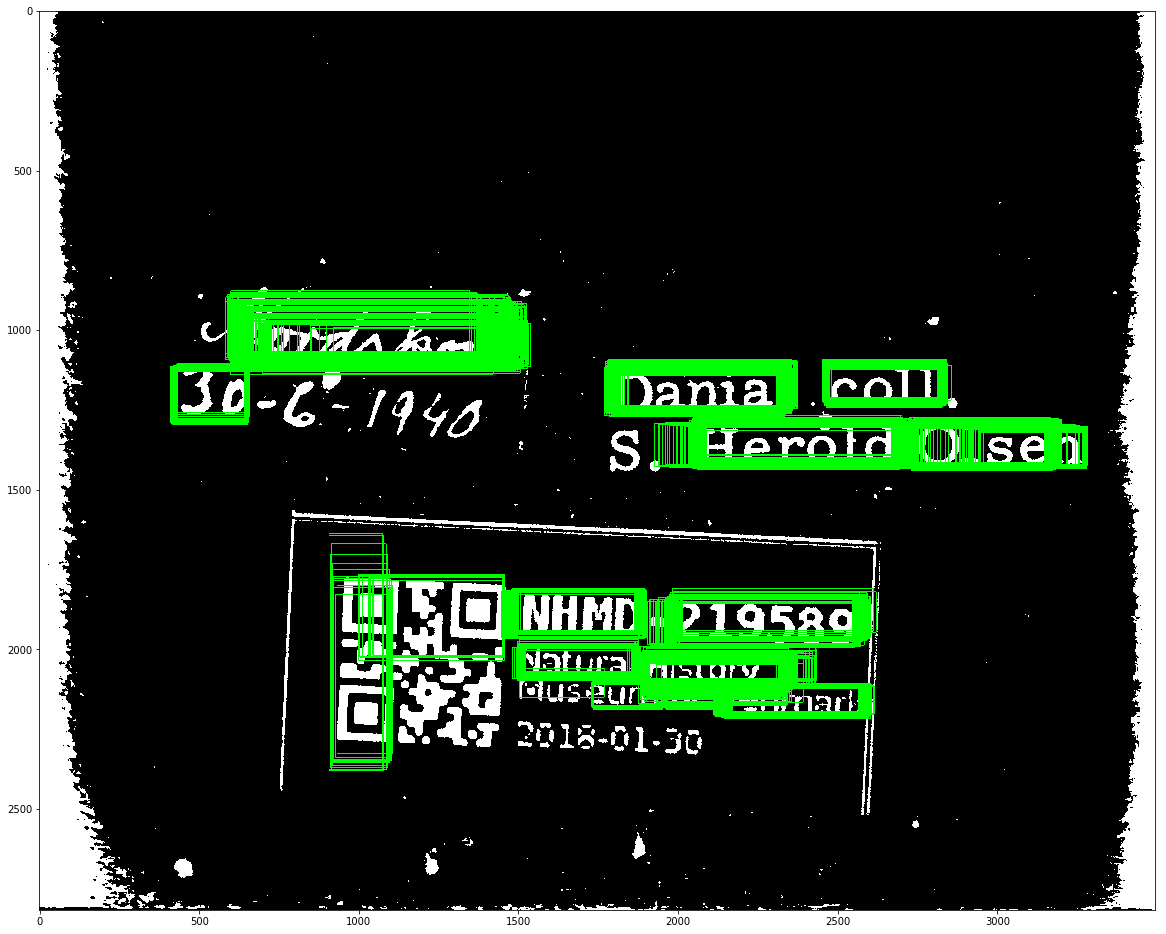

In [50]:
detect_text(a, show_image=True);

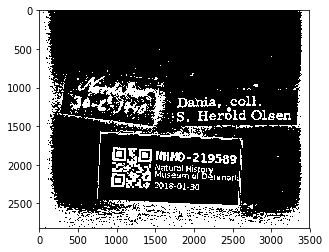

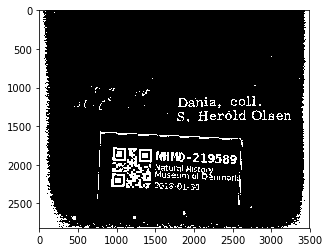

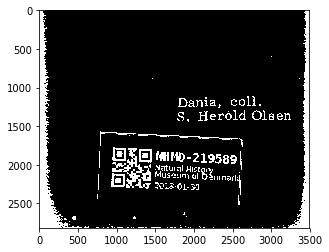

In [30]:
for i in range(3):
    a = img[:,:,i]
    _,th = cv2.threshold(cv2.cvtColor(cv2.merge((a,a,a)), cv2.COLOR_BGR2GRAY),190,255,cv2.THRESH_BINARY_INV)
    plt.figure()
    plt.imshow(cv2.merge((th,th,th)))

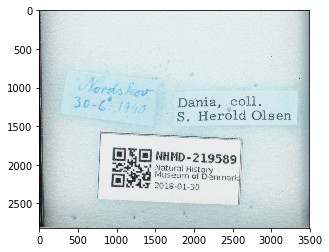

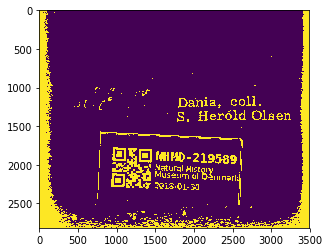

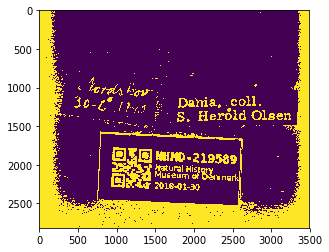

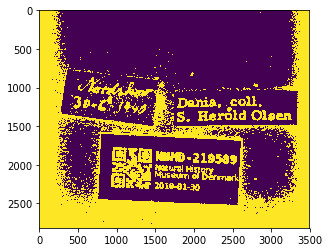

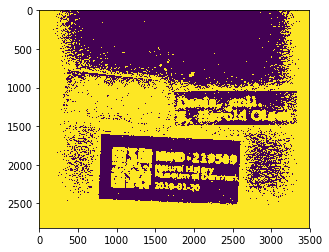

In [26]:
from pylab import arange, array, uint8
img = cv2.imread(fps[60])
plt.imshow(img)
maxIntensity = 255.0 # depends on dtype of image data
x = arange(maxIntensity) 

# Parameters for manipulating image data
phi = 1
theta = 1

for i in [2,3,4]:
    new = (maxIntensity/phi)*(img/(maxIntensity/theta))**i
    new = array(new,dtype=uint8)
    plt.figure()
    plt.imshow(new)
    
    _,th = cv2.threshold(cv2.cvtColor(new, cv2.COLOR_BGR2GRAY),150,255,cv2.THRESH_BINARY_INV)
    #kernel = np.ones((10,10),np.uint8)
    #d = cv2.dilate(th,kernel,iterations = 2)

    plt.imshow(th)

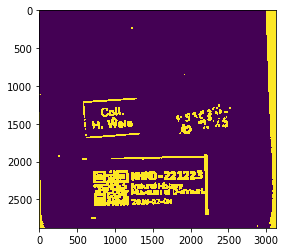

In [6]:

_,th = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY_INV)
kernel = np.ones((10,10),np.uint8)
d = cv2.dilate(th,kernel,iterations = 2)

plt.imshow(d)


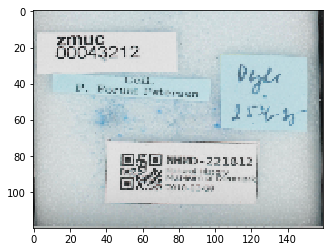

In [94]:
img = cv2.resize(cv2.imread(fps[0]), (160,120))
#img = cv2.GaussianBlur(img, (5,5), 2)
#img = img[1:]-img[:-1]
kernel = np.ones((3,3),np.uint8)
#img = cv2.erode(img,kernel,iterations = 2) 
#_,img = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY)
plt.imshow(img)

In [3]:
img = cv2.imread(fps[900])#60 is a good example

_,th = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),210,255,cv2.THRESH_BINARY_INV)

plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(th)

NameError: name 'fps' is not defined

[INFO] loading EAST text detector...
[INFO] text detection took 4.227168 seconds


-1

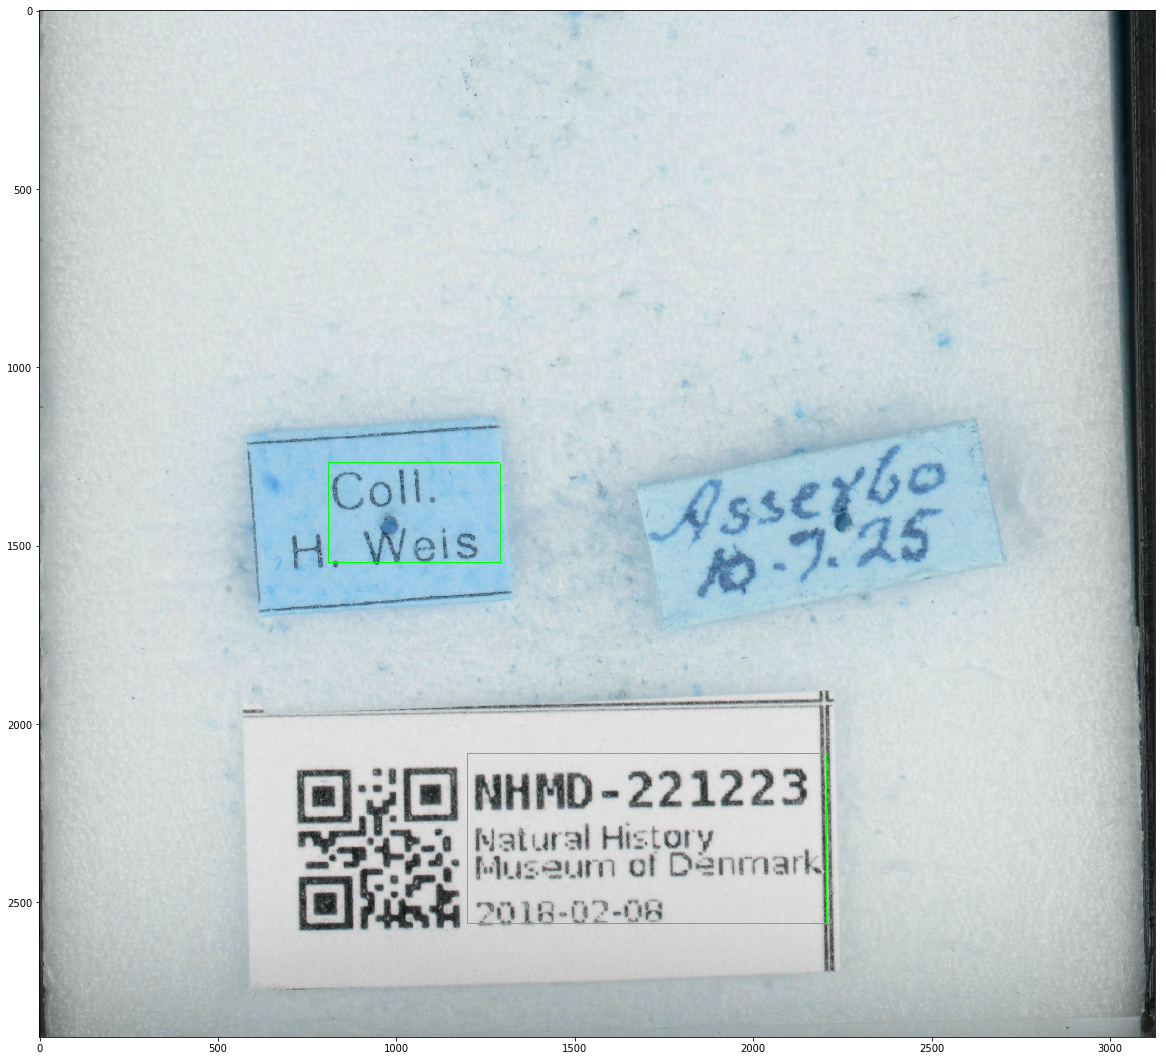

In [35]:

#for (startX, startY, endX, endY) in merged_rects:
#    cv2.rectangle(messy, (startX, startY), (endX, endY), (0, 255, 0), 2)

# show the output image
plt.figure(figsize=(20,20))
plt.imshow(img)
cv2.waitKey(0)

In [49]:
def detect_text(img, show_image = False):
    # load the input image and grab the image dimensions
    image = img
    orig = image.copy()
    (H, W) = image.shape[:2]
    (H/32,W/32)

    # set the new width and height and then determine the ratio in change
    # for both the width and height
    (newW, newH) = (11*32*4, 7*32*4)
    rW = W / float(newW)
    rH = H / float(newH)

    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]    

    # define the two output layer names for the EAST detector model that
    # we are interested -- the first is the output probabilities and the
    # second can be used to derive the bounding box coordinates of text
    layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]
    # load the pre-trained EAST text detector
    print("[INFO] loading EAST text detector...")
    net = cv2.dnn.readNet('frozen_east_text_detection.pb')

    # construct a blob from the image and then perform a forward pass of
    # the model to obtain the two output layer sets
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
    start = time.time()
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    end = time.time()

    # show timing information on text prediction
    print("[INFO] text detection took {:.6f} seconds".format(end - start))
    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]


        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < 0.8:
                continue

            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            # add the bounding box coordinates and probability score to
            # our respective lists
            
            startX = int(startX * rW)
            startY = int(startY * rH)
            endX = int(endX * rW)
            endY = int(endY * rH)
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
    
    if show_image == True:
        # loop over the bounding boxes
        for (startX, startY, endX, endY) in rects:
            # scale the bounding box coordinates based on the respective
            # ratios

            # draw the bounding box on the image
            cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

        # show the output image
        plt.figure(figsize=(20,20))
        plt.imshow(orig)
        cv2.waitKey(0)
    
    return rects

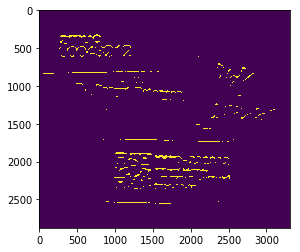

In [4]:
img = cv2.imread(fps[0])
img = cv2.GaussianBlur(img, (151,151), 10)
img = img[2:]-img[:-2]
kernel = np.ones((5,5),np.uint8)
img = cv2.erode(img,kernel,iterations = 4) 
_,img = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY)
plt.imshow(img)